In [1]:
import numpy as np
from sklearn.datasets import make_spd_matrix
import cvxpy as cp
import time
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
np.random.seed(42)

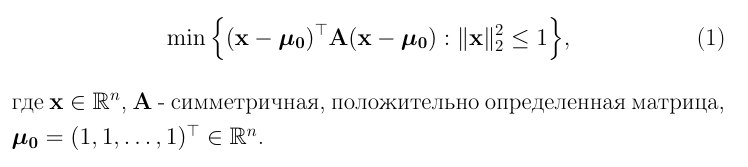

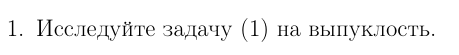

Функция $f(x)$ является квадратичной формой относительно $x$. 
Гессиан (вторая производная) этой функции $H(x) = 2A$. По условию матрица $A$ положительно определена, а значит и матрица $2A$ тоже положительно определена. Из этого следует, что функция $f(x)$ является выпуклой.

Ограничение можно записать как $g(x) = x^Tx \le 1$. Первая производная равна $2x$, а гессиан равен $2I$, где $I$ - единичная матрица. $2I$ положительно определена, а значит $g(x)$ - выпуклая функция. Из этого следует, что и ограничение $g(x) \le 1$ - выпуклое множество. Также можно сказать, что это это множество соответствует единичному шару в $\mathbb{R}^n$.

Таким образом, поскольку и функция цели, и множество ограничений выпуклы, оптимизационная задача является выпуклой.

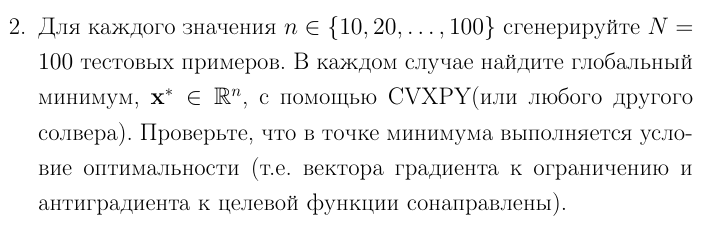

In [3]:
def solve_elipsoid(A, mu):

    x = cp.Variable(A.shape[0])

    objective = cp.Minimize(cp.quad_form(x - mu, A))

    constraints = [cp.norm2(x) <= 1]

    prob = cp.Problem(objective, constraints)

    result = prob.solve()

    return [x.value, result]

In [4]:
def solve_rand_elipsoids(
    n_dim: int = 2, n_samples: int = 100, random_states: list = None
):
    mu = np.ones(n_dim)

    if random_states is None:
        random_states = np.random.randint(0, 4294967295, size=n_samples)

    affine_ops = [make_spd_matrix(n_dim, random_state=state) for state in random_states]

    cases = []

    for A in affine_ops:

        cases.append([A] + list(solve_elipsoid(A, mu)))

    return cases

In [5]:
def quadform_grad(A, x, mu):
    return (A + A.T) @ x - (A + A.T) @ mu

In [6]:
def constraint_grad(x):
    return 2 * x

In [7]:
def is_kkt_optimal(grad_obj, grad_constraint, eps=0.01):

    dot = np.dot(-grad_obj, grad_constraint)
    norm_f = np.linalg.norm(grad_obj)
    norm_g = np.linalg.norm(grad_constraint)
    if norm_f < eps or norm_g < eps:
        return True
    cos_angle = dot / (norm_f * norm_g)

    return bool((np.abs(cos_angle - 1) < eps).all())

In [8]:
ndims = range(10, 110, 10)

In [9]:
print("+---------------------------------------+")
for dim in ndims:
    mu = np.ones(dim)
    time_start = time.time()
    all_optim_flag = np.all(
            np.asarray(
                [
                    is_kkt_optimal(
                        quadform_grad(case[0], case[1], mu), constraint_grad(case[1])
                    )
                    for case in solve_rand_elipsoids(dim)
                ]
            )
        )
    time_total = (time.time()-time_start)

    dim_str = str(dim)

    if len(dim_str) < 3:
        dim_str+=" "

    print(
        f"| dim={dim_str} | {all_optim_flag} | avg_time: {time_total/100:.4f} sec |",
    )
print("+---------------------------------------+")

print("^_^")

+---------------------------------------+
| dim=10  | True | avg_time: 0.0033 sec |
| dim=20  | True | avg_time: 0.0034 sec |
| dim=30  | True | avg_time: 0.0039 sec |
| dim=40  | True | avg_time: 0.0044 sec |
| dim=50  | True | avg_time: 0.0058 sec |
| dim=60  | True | avg_time: 0.0065 sec |
| dim=70  | True | avg_time: 0.0074 sec |
| dim=80  | True | avg_time: 0.0082 sec |
| dim=90  | True | avg_time: 0.0654 sec |
| dim=100 | True | avg_time: 0.0869 sec |
+---------------------------------------+
^_^


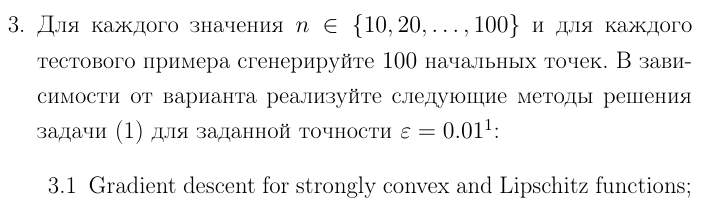

In [ ]:
def project_to_constraint(x):
    x_norm = np.linalg.norm(x)
    return x if x_norm <= 1 else x / x_norm

def gradient_descent(A, mu, x_init, f_star, eps=0.01, max_iters=10000):
    
    alpha = np.min(np.linalg.eigvals(A*2))

    lr = 2 / alpha

    x = x_init.copy()
    iterations = 0

    while iterations < max_iters:

        grad = quadform_grad(A, x, mu)
        x_new = project_to_constraint(x - lr/(iterations+1) * grad)
        f_val = (x_new - mu).T @ A @ (x_new - mu)

        x = x_new
        iterations += 1

        if f_val - f_star <= eps:
            break

    return x_new, iterations, f_val

In [11]:
def gd_rand_elipsoids_avg_stats(
    n_dim: int = 2, n_samples: int = 100, n_init_states = 100, random_states: list = None, eps=0.01
):
    mu = np.ones(n_dim)

    if random_states is None:
        random_states = np.random.randint(0, 4294967295, size=n_samples)

    affine_ops = [make_spd_matrix(n_dim, random_state=state) for state in random_states]
    
    iters_total = 0
    time_total = 0

    for A in affine_ops:

        solution = solve_elipsoid(A, mu)

        case_time_start = time.time()

        for _ in range(n_init_states):

            x_init = project_to_constraint(np.random.randn(n_dim))
            x_opt, iters, f_val = gradient_descent(A, mu, x_init, solution[-1], eps=eps)
            
            iters_total += iters
            
        time_total += time.time() - case_time_start

    return time_total/(n_samples*n_init_states) , iters_total/(n_samples*n_init_states)

In [12]:
print("+-----------------------------------------------------+")
for dim in ndims:
    
    dim_str = str(dim)

    if len(dim_str) < 3:
        dim_str+=" "

    stat = gd_rand_elipsoids_avg_stats(dim)

    print(
        f"| dim={dim_str} | avg_iters: {stat[1]:.4f} | avg_time: {stat[0]:.4f} sec |",
    )
print("+-----------------------------------------------------+")

print("^_^")

+-----------------------------------------------------+
| dim=10  | avg_iters: 14.9792 | avg_time: 0.0001 sec |
| dim=20  | avg_iters: 19.7876 | avg_time: 0.0002 sec |
| dim=30  | avg_iters: 23.7223 | avg_time: 0.0003 sec |
| dim=40  | avg_iters: 24.8040 | avg_time: 0.0004 sec |
| dim=50  | avg_iters: 26.8417 | avg_time: 0.0006 sec |
| dim=60  | avg_iters: 32.0066 | avg_time: 0.0009 sec |
| dim=70  | avg_iters: 32.8760 | avg_time: 0.0012 sec |
| dim=80  | avg_iters: 37.5470 | avg_time: 0.0016 sec |
| dim=90  | avg_iters: 35.7905 | avg_time: 0.0020 sec |
| dim=100 | avg_iters: 44.4094 | avg_time: 0.0078 sec |
+-----------------------------------------------------+
^_^


#5

In [13]:
def gd_rand_elipsoids_sol_stats(
    n_dim: int = 2, n_samples: int = 100, n_init_states = 100, random_states: list = None, eps=0.01
):
    mu = np.ones(n_dim)

    if random_states is None:
        random_states = np.random.randint(0, 4294967295, size=n_samples)

    affine_ops = [make_spd_matrix(n_dim, random_state=state) for state in random_states]
    
    cases = []

    for i, A in enumerate(affine_ops):

        solution = solve_elipsoid(A, mu)

        eig_vigals = np.sort(np.abs(np.linalg.eigvals(A)))
        conditional_number = eig_vigals[-1] / eig_vigals[0]


        for _ in range(n_init_states):

            x_init = project_to_constraint(np.random.randn(n_dim))
            x_opt, iters, f_val = gradient_descent(A, mu, x_init, solution[-1], eps=eps)
            
            cases.append({
                "example_id" : i,
                "conditional_number": conditional_number,
                "Lipsitz_L" : eig_vigals[-1],
                "strong_convesity_alpha": np.min(np.linalg.eigvals(2*A)),
                "is_kkt_optimal": is_kkt_optimal(quadform_grad(A, x_opt, mu), constraint_grad(x_opt)),
                "solution_delta": np.abs(solution[-1] - f_val),
                "iters" : iters
            })

    return pd.DataFrame.from_records(cases)

In [14]:
dim_10_spectral_stats = gd_rand_elipsoids_sol_stats(10)

In [15]:
dim_10_spectral_stats

,example_id,conditional_number,Lipsitz_L,strong_convesity_alpha,is_kkt_optimal,solution_delta,iters
0,0,269.584847,10.357786,0.076842,True,0.007805,14
1,0,269.584847,10.357786,0.076842,True,0.007082,13
2,0,269.584847,10.357786,0.076842,True,0.009952,12
3,0,269.584847,10.357786,0.076842,True,0.007922,15
4,0,269.584847,10.357786,0.076842,True,0.007296,15
...,...,...,...,...,...,...,...
9995,99,51.057617,10.424980,0.408361,True,0.008454,17
9996,99,51.057617,10.424980,0.408361,True,0.009845,16
9997,99,51.057617,10.424980,0.408361,True,0.007565,17
9998,99,51.057617,10.424980,0.408361,True,0.008379,16


#5.2

In [16]:
ex_0 = dim_10_spectral_stats[dim_10_spectral_stats.example_id == 0]

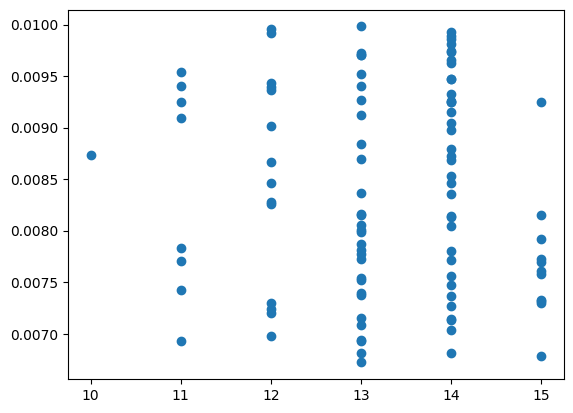

In [17]:
plt.scatter(ex_0["iters"], ex_0["solution_delta"])

In [18]:
dim_10_spectral_stats_agg = dim_10_spectral_stats.groupby("example_id").mean()

In [19]:
dim_10_spectral_stats_agg

,conditional_number,Lipsitz_L,strong_convesity_alpha,is_kkt_optimal,solution_delta,iters
example_id,,,,,,
0,269.584847,10.357786,0.076842,1.0,0.008360,13.25
1,83.820223,10.549249,0.251711,1.0,0.007668,10.31
2,730.794375,10.494132,0.028720,1.0,0.006908,8.53
3,37.427124,10.577378,0.565225,1.0,0.007936,12.67
4,106.570269,10.497433,0.197005,1.0,0.008109,13.66
...,...,...,...,...,...,...
95,127.984582,10.401638,0.162545,1.0,0.008206,11.82
96,134.639361,10.552064,0.156746,1.0,0.007759,11.76
97,89.529014,10.547020,0.235611,1.0,0.007369,10.99


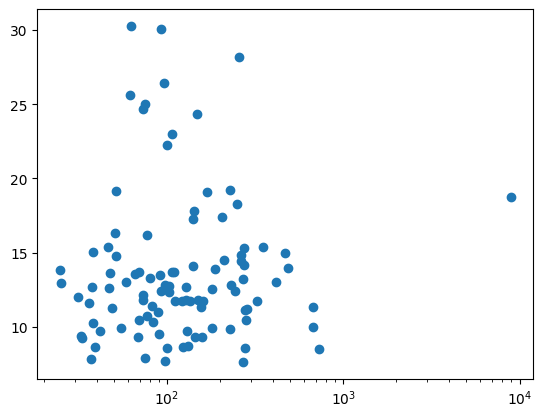

In [20]:
plt.xscale('log')
plt.scatter(dim_10_spectral_stats_agg["conditional_number"], dim_10_spectral_stats_agg["iters"])